In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow as tf
import numpy as np

from architectures.lstm_models import Encoder, Decoder, LSTM_Autoencoder
from helpers.data import load_keras_dataset
from metrics.psnr_hvs import compute_psnr_hvs

# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.optimizers.schedules import ExponentialDecay

tf.config.run_functions_eagerly(True)

2024-04-09 11:06:56.265188: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 11:06:56.480033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 11:06:57.526498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/cezar/anaconda3/envs/disertatie/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as not

PyTorch not installed, if you wish to use PyTorch, install as psnr_hvsm[torch]:
$> pip install psnr_hvsm[torch]


In [2]:
BINARY_SIZE = 16
PATCH_SIZE = 8
STEPS = 16
BATCH_SIZE = 128

In [3]:
network = LSTM_Autoencoder(BATCH_SIZE, BINARY_SIZE, PATCH_SIZE, STEPS)

2024-04-09 11:06:59.554178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 11:06:59.718188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 11:06:59.718240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 11:06:59.724724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 11:06:59.724782: I tensorflow/compile

In [4]:
def load_dataset(dataset_name):
    import keras.datasets as datasets
    (x_train, _), (x_test, _) = getattr(datasets, dataset_name).load_data()

    x_train = np.append(x_train, x_test, axis=0)
    x_train = x_train.astype('float32') / 127.5 - 1
    return x_train

def get_data():
    cifar10_dataset = load_dataset('cifar10')
    cifar100_dataset = load_dataset('cifar100')
    stl10_dataset = load_dataset('stl10')

    # append the datasets
    dataset = np.append(cifar10_dataset, cifar100_dataset, axis=0)
    dataset = np.append(dataset, stl10_dataset, axis=0)
    
    return dataset

def get_simple_data():
    cifar10_dataset = load_dataset('cifar10')

    return cifar10_dataset

In [5]:
dataset = get_simple_data()

In [6]:
dataset = tf.image.extract_patches(dataset, sizes=[1, PATCH_SIZE, PATCH_SIZE, 1], strides=[1, PATCH_SIZE, PATCH_SIZE, 1], rates=[1, 1, 1, 1], padding='VALID')

In [7]:
# flatten the data
dataset = tf.reshape(dataset, [-1, PATCH_SIZE, PATCH_SIZE, 3])
print(dataset.shape)

(960000, 8, 8, 3)


In [8]:
def ssim_loss(y_true, y_pred):
    # get the luma values
    y_true = (y_true + 1) / 2
    y_pred = (y_pred + 1) / 2

    return tf.reduce_mean(1 - tf.image.ssim(y_true, y_pred, max_val=1))

optimizer = Adam(learning_rate=0.0001)
network.compile(optimizer=optimizer, loss='mse')

In [9]:
tf.config.run_functions_eagerly(False)
network.fit(dataset, dataset, epochs=15, shuffle=True, batch_size=BATCH_SIZE)

2024-04-09 11:07:08.115568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-09 11:07:08.277161: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fe6166eb710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-09 11:07:08.277271: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-04-09 11:07:08.315551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-09 11:07:08.465699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907
2024-04-09 11:07:08.724320: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-09 

7500/7500 [==============================] - 395s 52ms/step - loss: 17.6865


In [10]:
sample_images = dataset[:16]
# extend sample images to have 128 images
sample_images = tf.tile(sample_images, [8, 1, 1, 1])
sample_images = tf.reshape(sample_images, [-1, PATCH_SIZE, PATCH_SIZE, 3])
print(sample_images.shape)
reconstructed_images = network.predict(sample_images, batch_size=BATCH_SIZE)
reconstructed_images = (-reconstructed_images + 1) / 2
#reconstructed_images = tf.clip_by_value(reconstructed_images, 0, 1)

(128, 8, 8, 3)


1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

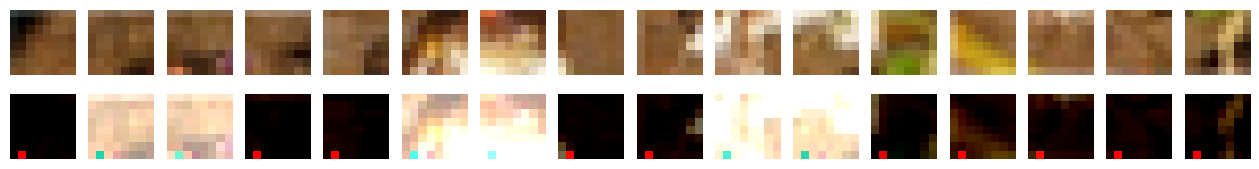

In [11]:
# plot the images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 16, figsize=(16, 2))
for i in range(16):
    axes[0, i].imshow((sample_images[i] + 1)/2)
    axes[1, i].imshow(reconstructed_images[i])
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


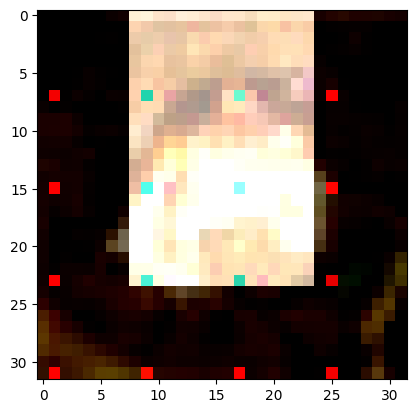

In [12]:
# create an image of size 32x32
reconstruction = np.zeros((32, 32, 3))
for i in range(4):
    for j in range(4):
        reconstruction[i*8:i*8+8, j*8:j*8+8] = reconstructed_images[i*4+j]
    
plt.imshow(reconstruction)
plt.show()


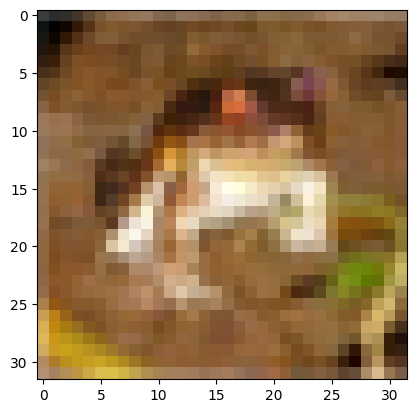

In [13]:
initial = np.zeros((32, 32, 3))
for i in range(4):
    for j in range(4):
        initial[i*8:i*8+8, j*8:j*8+8] = sample_images[i*4+j]

plt.imshow((initial + 1) / 2)
plt.show()
